<a href="https://colab.research.google.com/github/maicon-reis/data-science-projects/blob/maicon-reis-datasets/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/12/900.jpg" width="60%"></p>

Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## **1. Importando os Dados**

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/12/54.jpg" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [1]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve

# configurando o estilo dos gráficos com o Seaborn
sns.set_style( 'dark' )

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Os dados foram importados para dentro de uma estrutura de *Dataframe*, podendo então iniciar-se a análise exploratória dos dados e logo após a preparação destes para o(s) modelo(s) de *Machine Learning*.

In [2]:
# associando caminho do arquivo a variável
arquivo = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df_creditcard = pd.read_csv(arquivo)

## **2. Análise Exploratória**

Inicialmente vou criar uma cópia dos dados e em seguida visualizar as cinco primeiras entradas a fim de entender a estrutura dos dados.

Meu segundo procedimento foi entender a dimensionalidade do *Dataframe* (quantidades de linhas e colunas), tipos dos dados e valores faltantes.

In [4]:
# criando uma cópia dos dados
df = df_creditcard.copy()

# visualizando as cinco primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


O *Dataframe* possui somente entradas numéricas e é composto por 284807 entradas e 05 colunas.

Além das colunas *Time* (tempo em segundos) e da coluna *Amount* (valor da transação) e *Class* (variável alvo), o *Dataframe* possui 28 (vinte e oito) variáveis nemenclaturadas de V1 a V28, que são atributos numéricos e descaraterizados por motivos ligados à privacidade e a segurança.

Como o *dataset* não apresentou valores ausentes, não foi necessária a limpeza.

Resta acrescentar que a variável alvo, *Class*, possui dois valores booleanos onde:
* 0: Representa uma transação normal; e 
* 1: Representa uma transação com fraude.

Tendo essa informação em mente passei a analisar a qualidade dos dados tendo em vista o balanceamento entre os valores.

In [5]:
# visualizando a quantidade de linhas e colunas do dataset
n_linhas, n_colunas = df.shape

print(f'Número de linhas: {n_linhas}')
print(f'Número de linhas: {n_colunas}\n')

# verificando formato das variáveis do dataset
df.info()

Número de linhas: 284807
Número de linhas: 31

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V

In [6]:
# verificando dados faltantates no dataset
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Verificando o resultado abaixo notei que, como já dito acima, há um forte desbalanceamento entro os dados, em que os dados fraudulentos representam somente 0,17% do total o que necessitará posterior técnica de balanceamento antes da utilização do modelo de *Machine Learning* tendo em vista que a permanência dessa característica pode afetar os resultados do modelo.

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.17%



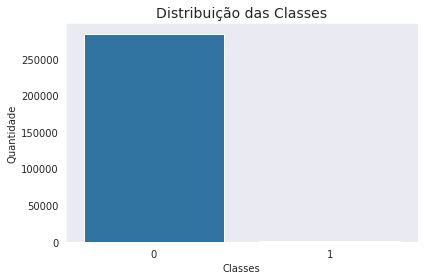

In [7]:
# plotando os dados numéricos da Series 'Class'
print( df.Class.value_counts() )
qtd_fraudes  = df[ df.Class == 1 ].shape[ 0 ] / df.shape[ 0 ] * 100
print(f'\nFraudes representam {qtd_fraudes:.2f}%\n')

# verificando graficamente
fig = plt.subplots( figsize=( 6, 4 ) )
sns.countplot( x='Class', data=df )
plt.title( 'Distribuição das Classes', fontsize=14 )
plt.ylabel( 'Quantidade', fontsize=10 )
plt.xlabel( 'Classes', fontsize=10 )

plt.tight_layout()
plt.show()

Plotei o gráfico de dispersão da variável tempo em relação ao tipo da variável alvo, *Class*, porém não foi visualizado nada representativo.

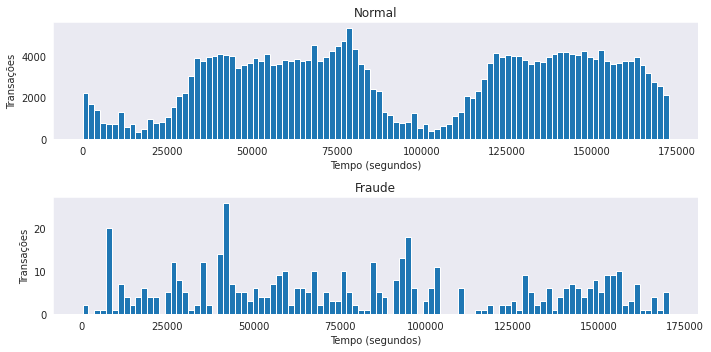

In [8]:
# verificando as Classes de Transações normais e fraudulentas no tempo
fig, ax =plt.subplots( nrows=2, ncols=1, figsize=( 10, 5 ) )

ax[0].hist( df.Time[ df.Class ==0 ], bins=100 )
ax[1].hist( df.Time[ df.Class ==1 ], bins=100 )

ax[0].set_title( 'Normal' )
ax[0].set_ylabel( 'Transações' )
ax[0].set_xlabel( 'Tempo (segundos)' )

ax[1].set_title( 'Fraude' )
ax[1].set_ylabel( 'Transações' )
ax[1].set_xlabel( 'Tempo (segundos)' )

plt.tight_layout()
plt.show()

Verificando a dispersão dos valores fraudados através da análise da coluna 'Amount', vefica-se que o montante fraudado é bastante disperso atingindo até um montante de 2125.87, e tal fato faz com quem a média, mediana e moda sejam bastante diferentes. Por fim, o valor mais fraudado é 1.0.

Informações sobre a variável 'Amount' das operações fraudulentas (Class = 1)

Valor Máximo: 2125.87
Media: 122.21
Mediana: 9.25
Moda: 1.0
Valor Mínimo: 0.0



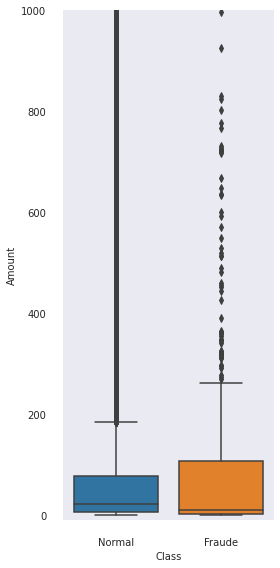

In [15]:
# verificando dados sobre os valores fraudados
max = df[ ( df.Class == 1 ) ][ 'Amount' ].max()
min = df[ ( df.Class == 1 ) ][ 'Amount' ].min()
media = df[ ( df.Class == 1 ) ][ 'Amount' ].mean()
mediana = df[ ( df.Class == 1 ) ][ 'Amount' ].median()
moda = df[ ( df.Class == 1 ) ][ 'Amount' ].mode()[ 0 ]
print(f"Informações sobre a variável 'Amount' das operações fraudulentas (Class = 1)\n")
print(f'Valor Máximo: {max}')
print(f'Media: {media:.2f}')
print(f'Mediana: {mediana}')
print(f'Moda: {moda}')
print(f'Valor Mínimo: {min}\n')

# criando gráfico de boxplot do montante dos valores fraudados
fig = plt.subplots( figsize=( 4, 8 ) )

sns.boxplot(x='Class', y='Amount', data=df )

plt.ylim( ( -10, 1000 ) )
plt.xticks( [ 0, 1 ], [ 'Normal', 'Fraude' ])

sns.despine(offset=10, trim=True)

plt.tight_layout()
plt.show()

Plotando gráfico de dispersão das variáveis V1 a V28, separando as amostras pela variável 'Class' entre Normal e Fraude. Percebi que a diferença de forma entre os formatos nas variáveis mostram que algumas variáveis terão mais utilidades para o modelo que outras, como por exemplo as variáveis (V1, V3, V4, V11, V12, V14, V16, V17, V18, V19). Já outras variáveis pouco acrescentarão no modelo tendo em vista terem formatos bastante parecidos quando a 'Class' é 0 (Normal) e 1 (fraudulenta).

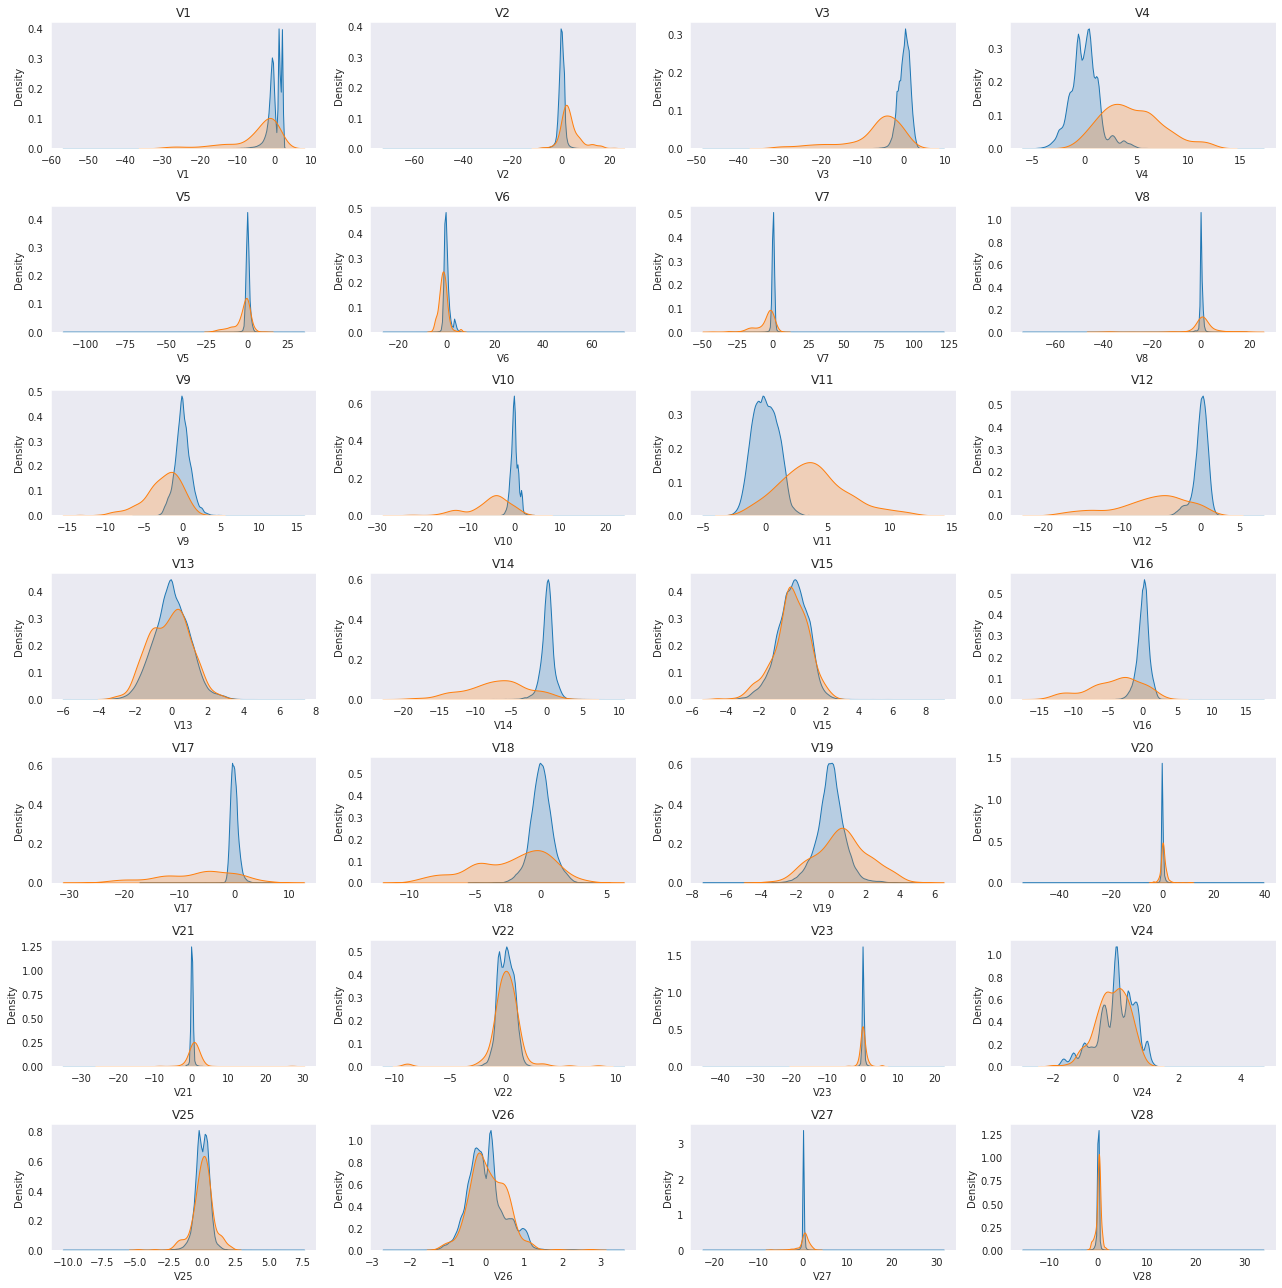

In [10]:
 # informações sobre as variáveis de V1 a V28
colunas = df.drop( columns=[ 'Class', 'Amount', 'Time' ] ).columns
qtd = len( colunas )
df_0 = df[ df.Class == 0 ]
df_1 = df[ df.Class == 1 ]

# plotando gráfics de dispersão
fig, ax = plt.subplots( nrows=7, ncols=4, figsize=( 18, 18 ) )
fig.subplots_adjust( hspace=1, wspace=1 )
idx = 0
for coluna in colunas:
  idx += 1
  plt.subplot( 7, 4, idx )
  sns.kdeplot( df_0[ coluna ], label='Classe 0', shade=True )
  sns.kdeplot( df_1[ coluna ], label='Classe 1', shade=True )
  plt.title( coluna )

plt.tight_layout()
plt.show()

Criando um mapa de calor entre as variáveis, verifica-se que as variáveis de V1 a V28 não possuem correlação entre si. Somente entre elas e as variáveis 'Time' e 'Amount'. Tal fato pode caracterizar-se pelo desbalanceamento da variável alvo, 'Class', que se reflete por toda a base de dados.

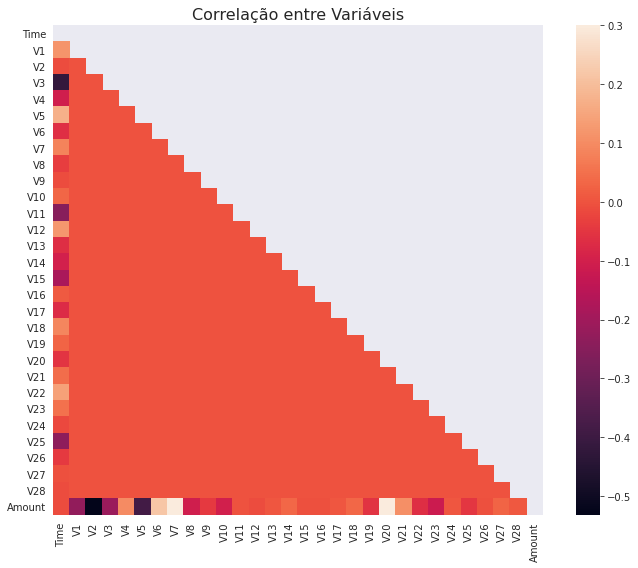

In [16]:
# gera matriz de correlação
corr = df.drop('Class', axis=1).corr()

# gera uma máscara ocultar o triângulo superior
mask = np.zeros_like( corr )
mask[ np.triu_indices_from( mask ) ] = True

# cria um mapa de calor para a correlação entre as variáveis
with sns.axes_style( "dark" ):
    f, ax = plt.subplots( figsize=(10, 8) )
    ax = sns.heatmap( corr, mask=mask, vmax=.3, square=True )
    ax.set_title('Correlação entre Variáveis', fontsize=16)

    plt.tight_layout()
    plt.show()

## **Preparação dos Dados**

Primeiramente eu fiz uma padronização dos dados utilizando o algoritmo StandardScaler, fazendo com que as variáveis 'Time' e 'Amount' sofram mudança na escala para se adequar ao restante do Dataset, e armazenei o resultado em novas variáveis ('Time_pad' e 'Amount_pad'), excluindo, posteriormente as variáveis antigas.

In [17]:
# criando uma cópia do dataframe
df_2 = df_creditcard.copy()

# Padronizando os valores das variáveis 'Time' e 'Amount' com StandardSca

# instanciando o StandardScaler
scaler = StandardScaler()

# tranformando os dados
df_2.loc[:, 'Time_pad'] = scaler.fit_transform(df_2['Time'].values.reshape(-1, 1))
df_2.loc[:, 'Amount_pad'] = scaler.fit_transform(df_2.Amount.values.reshape(-1, 1))

# deletando as Series 'Time' e 'Amount'
df_2.drop(['Time', 'Amount'], axis=1, inplace=True)

Após a padronização dos dados, eu os separei a matriz das variáveis (X) e o vetor alvo (y) e após isso separei os dados em treino e teste sendo 70% dos dados para treino e 30% para teste.

Veja que para treinar o modelo eu só utilizei as cinco variáveis que transmitem mais informações ao modelo, para isso eu utilizei o algoritmo ```DecisionTree```, notadamente a propriedade ```feature_importance_```. O código dessa otimização pode ser conferido no tópico ```Apêndice```.

Feito isso, eu rebalancei os dados de treino para que eu tivesse na variável alvo uma quantidade proporcional entre operações normais e fraudulenta, como pode ser verificado no gráfico de barras. Para tanto utilizei um algoritmo de *undersampling* chamado ```NearMiss```, com isso eu busquei reduzir de forma aleatória os exemplos da classe majoritária.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    344
0    344
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


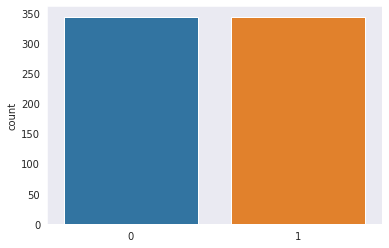

In [18]:
# separando a variável das features e a variável da classe
X = df_2[['V10', 'V12', 'V14', 'V17', 'V27']]
y = df_2[ 'Class' ]

# divindo os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split( X, y
                                                        , test_size=0.3
                                                        , stratify=y
                                                        , shuffle=True)

# balanceando as variáveis com o módulo SMOTE
np.random.seed(42)
nm = NearMiss()
X_nm, y_nm = nm.fit_sample( X_treino, y_treino )

# tranformando em Series
print(
    pd.Series(y_nm).value_counts()
    )

# plotando a nova distribuição de classes
sns.countplot(y_nm)

## **Modelo de Machine Learning**

Realizada toda a preparação, tratamento e separação dos dados, parte-se para a fase de construção de um classificador. Dentre os modelos que eu utilizei para essa base de dados o que melhor performou foi a Regressão Logística (```LogisticRegression```).

Dentre os parâmetros que utilizei os que ofereceram o melhor resultado foram os que seguem no instanciamento do algoritmo. Feito isso eu treinei o algoritmo com dos dados ```X_nm``` e ```y_nm```.

In [19]:
# instanciando e treinando o algoritmo
np.random.seed(42)
lr_clf = LogisticRegression(penalty='l1', random_state=0, solver='saga')

# treinando o algoritmo com dados de treino balanceados
lr_clf.fit( X_nm, y_nm )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

## Avaliando o desempenho do modelo

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho.

Como a base de dados, originalmente, está desbalanceada, utilizar a acurácia pode incorrer em erro, pois, como pode-se visualizar abaixo, apesar de eu obter uma Acurácia com Validação Cruzada de ```99,90%```. A precisão em detectar uma fraude corretamente ficou pouco acima de 80%.

In [20]:
def Acuracia( clf, X, y):
  resultados = cross_val_predict( clf, X, y, cv=5 )
  return metrics.accuracy_score( y, resultados )

# predizendo a classe com dados de teste
y_pred = lr_clf.predict( X_teste )

print("--------------- Classification Report ---------------")
# gerando relatório de classificação
print(
    metrics.classification_report( 
        y_teste, y_pred, digits=4
    )
)

print()

print("---------------- Matriz de Confusão ----------------")
# gerando matriz de confusão
print(
    pd.crosstab( y_teste, y_pred, rownames=['Real'], colnames=['      Predito'], margins=True)
)
print()

print("---------- Acurácia com Validação Cruzada ----------")
print()
# verificando o modelo com validação cruzada
Acuracia(lr_clf, X_teste, y_teste)

--------------- Classification Report ---------------
              precision    recall  f1-score   support

           0     0.9997    0.9894    0.9945     85295
           1     0.1183    0.8176    0.2067       148

    accuracy                         0.9891     85443
   macro avg     0.5590    0.9035    0.6006     85443
weighted avg     0.9982    0.9891    0.9932     85443


---------------- Matriz de Confusão ----------------
      Predito      0     1    All
Real                             
0              84393   902  85295
1                 27   121    148
All            84420  1023  85443

---------- Acurácia com Validação Cruzada ----------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

0.9990402958697612

Uma outra forma de avaliar a eficária desse tipo de modelo é utilizando a curva ROC, ou área sob a curva.

Essa curva descreve o quando o modelo é capaz de distinguir as diferentes classes. A curva ROC é um gráfico de True Positive Rate (TPR, Recall ou Sensitivity ) em função do False Positive Rate (FPR), onde:

```
TPR = True Positives / (True Positives + False Negatives)
```
```
FPR = False Positives / (False Positives + True Negatives)
```
Quanto mais próximo de 1 for o AUC, melhor a capacidade do modelo em separar as classes. Nosso modelo apresentou um AUC de ```0.954```, o que significa que esse modelo é eficiente em encontrar uma transação fraudulenta em meio a transações normais.




Sem Treino: ROC AUC= 0.500
Logistic: ROC AUC= 0.954



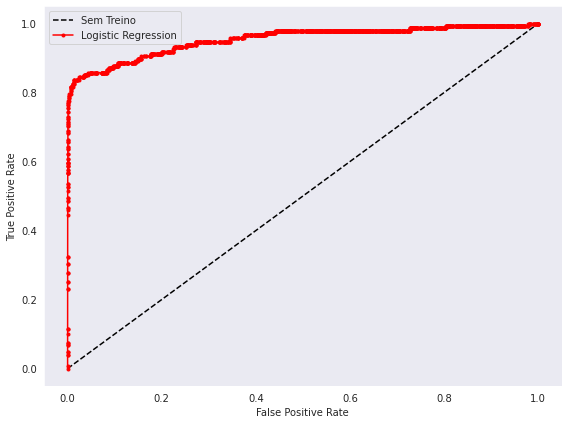

In [21]:
# gerando uma predição sem treino (classe majoritária)
ns_probs = [ 1 for _ in range( len( y_teste ) ) ]

# predizendo probabilidades
lr_probs = lr_clf.predict_proba( X_teste )

# manter as probabilidade somente para o resultado positivo
lr_probs = lr_probs[:, 1]

# calculando os scores
ns_auc = roc_auc_score( y_teste, ns_probs )
lr_auc = roc_auc_score( y_teste, lr_probs )

# resumos dos scores
print(f'\nSem Treino: ROC AUC= {ns_auc:.3f}')
print(f'Logistic: ROC AUC= {lr_auc:.3f}\n')

# calculando curvas roc
ns_fpr, ns_tpr, _ = roc_curve( y_teste, ns_probs )
lr_fpr, lr_tpr, _ = roc_curve( y_teste, lr_probs )

# criando a curva roc para o modelo
fig = plt.subplots( figsize=(8,6))
plt.plot(ns_fpr, ns_tpr, linestyle='dashed', color='black', label='Sem Treino')
plt.plot(lr_fpr, lr_tpr, marker='.', color='red', label='Logistic Regression')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.tight_layout()
plt.show()

## **Conclusão**

Inicialmente, poderia pensar-se que o resultado do algoritmo não foi satisfatório se utilizado o critério de precisão em quem o algoritmo identificou 2210 casos que supostamente seria fraude, sendo que desse total somente 128 eram realmente fraude, ou seja uma precisão de ```5,79%```. Mas esse não é o viés correto a ser interpretado, tendo em vista o montante de operações processadas ```85443```, das quais somente ```148 (0,17%)``` eram fraudes, e o sistema conseguiu identificar com exatidão ```121 (86,49%)``` sacrificando um total de ```902``` operações normais que foram consideradas fraudadas, o que corresponde a ```2,44%``` das operações normais. O que pode ser considerado um resultado excelente obtido pelo algoritmo criado, tendo em vista que a capacidade de distinção entre as classes medida pelo AUC ROC é de ```0.959```.

## **Apêndice**

Utilizando o algoritmo Árvore de Decisão para selecionar as variáveis que tem maior Ganho de Informação (GI), para otimizar o modelo.

In [ ]:
#criando uma cópia do dataset
df_copy = df_creditcard.copy()

X = df_copy.drop('Class', axis=1)
y = df_copy['Class']

# balanceando as variáveis com o módulo SMOTE
nm = NearMiss()
X_nm, y_nm = nm.fit_sample( X, y )

# instanciando e treinando o algoritmo
dt_clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best').fit( X, y )

fi = dt_clf.feature_importances_

l = len( X.columns )
for i in range(0, l):
  print(f'{X.columns[i]} ({fi[i]:.4f})')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
